### 준비물

- x데이터: 노이즈 있는 사진
    - 노이즈 없는 깨끗한 원본사진에 노이즈를 추가하여서 x데이터를 준비
- y데이터: 노이즈 없는 깨끗한 사진

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, Flatten, Reshape
from keras import layers
from tensorflow.keras.models import Model
from keras.models import Sequential

from skimage import color

In [11]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images,
                               test_labels) = fashion_mnist.load_data()

### 데이터 전처리

In [12]:
np.shape(train_images), np.shape(train_labels), np.shape(test_images)

((60000, 28, 28), (60000,), (10000, 28, 28))

In [13]:
train_images.min(), train_images.max(), test_images.min(), test_images.max()

(0, 255, 0, 255)

In [14]:
# 정수형에서 실수형으로 변경
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)

In [15]:
train_images.min(), train_images.max(), test_images.min(), test_images.max(
), train_images.dtype

(0.0, 255.0, 0.0, 255.0, dtype('float64'))

In [16]:
# 정규화 또는 표준화 작업
train_images = train_images / 255
test_images = test_images / 255

In [17]:
train_images.min(), train_images.max(), test_images.min(), test_images.max(
), train_images.dtype

(0.0, 1.0, 0.0, 1.0, dtype('float64'))

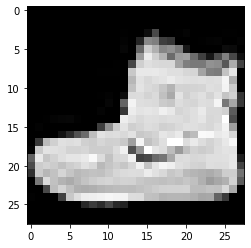

In [18]:
plt.imshow(train_images[0], cmap='gray')

In [19]:
# 흑백이미지를 컬러이미지로 변경: (28, 28) => (28, 28, 3)

train_images = color.gray2rgb(train_images)
test_images = color.gray2rgb(test_images)

### 노이즈 추가

(0.3269978048449307, 0.6652345908847807)

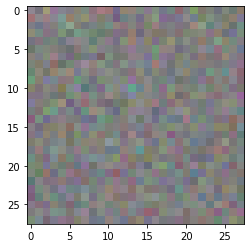

In [20]:
noise = np.random.normal(0.5, 0.05, (28, 28, 3))
plt.imshow(noise)
noise.min(), noise.max()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


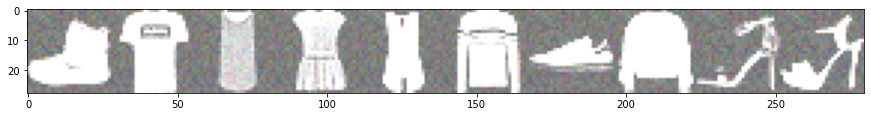

In [21]:
plt.figure(figsize=(15, 3))
train_images_noise = train_images + noise
plt.imshow(np.hstack(train_images_noise[:10]))

In [22]:
test_images_noise = test_images + noise

In [23]:
train_images_noise.min(), train_images_noise.max()

(0.3269978048449307, 1.6652345908847805)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


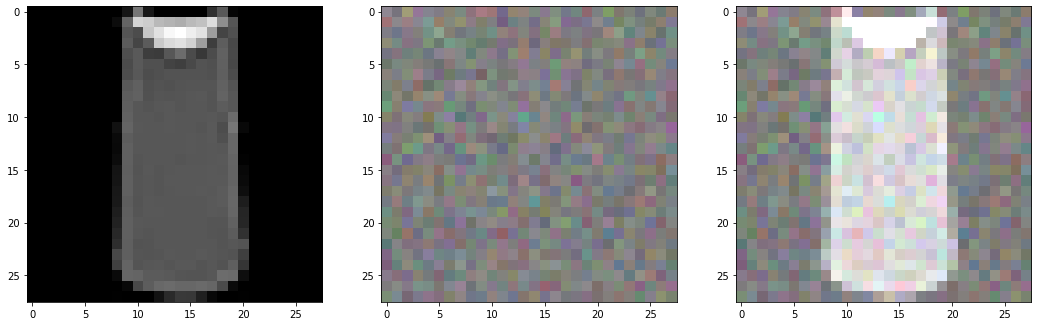

In [24]:
plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.imshow(train_images[2])

plt.subplot(1, 3, 2)
plt.imshow(noise)

plt.subplot(1, 3, 3)
plt.imshow(train_images[2] + noise)

plt.show()

### 오토인코더 모델 구성

In [25]:
inputs = Input(shape=(28, 28, 3))  # 28, 28, 3
x = Conv2D(32, 3, activation='relu', padding='same')(inputs)  # 28, 28, 32
x = Conv2D(64, 3, activation='relu', padding='same')(x)  # 28, 28, 64
x = Flatten()(x)  # 28 * 28 * 64개의 픽셀 생성
last = Dense(10)(x)  # 10개 * (50176 + bias1) => 501770개 params

x = Dense(28 * 28 * 64)(last)
x = Reshape((28, 28, 64))(x)

x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = Conv2D(3, 3, activation='sigmoid', padding='same')(x)

In [26]:
model = Model(inputs, x)

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                501770    
_________________________________________________________________
dense_1 (Dense)              (None, 50176)             551936    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 64)        0     

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
history = model.fit(train_images_noise,
                    train_images,
                    verbose=1,
                    epochs=5,
                    validation_data=(test_images_noise, test_images))

Epoch 1/5
1875/1875 [==============================] - 15s 6ms/step - loss: 0.2983 - accuracy: 0.3497 - val_loss: 0.2845 - val_accuracy: 0.3271
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2805 - accuracy: 0.3392 - val_loss: 0.2807 - val_accuracy: 0.3508
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2776 - accuracy: 0.3618 - val_loss: 0.2793 - val_accuracy: 0.4112
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2760 - accuracy: 0.3677 - val_loss: 0.2779 - val_accuracy: 0.3682
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2751 - accuracy: 0.3677 - val_loss: 0.2783 - val_accuracy: 0.3725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


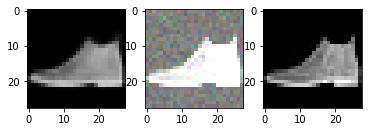

In [30]:
y_hat = model.predict(test_images_noise[:1])

plt.subplot(1, 3, 1)
plt.imshow(y_hat[0])

plt.subplot(1, 3, 2)
plt.imshow(test_images_noise[0])

plt.subplot(1, 3, 3)
plt.imshow(test_images[0])

In [31]:
class Denoise(Model):

    def __init__(self, in_ch=3):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, in_ch)),
            layers.Conv2D(32, 3, activation='relu', padding='same', strides=1),
            layers.Conv2D(16, (3, 3),
                          activation='relu',
                          padding='same',
                          strides=2),
            layers.Conv2D(8, (3, 3),
                          activation='relu',
                          padding='same',
                          strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8,
                                   kernel_size=3,
                                   strides=2,
                                   activation='relu',
                                   padding='same'),
            layers.Conv2DTranspose(16,
                                   kernel_size=3,
                                   strides=2,
                                   activation='relu',
                                   padding='same'),
            layers.Conv2DTranspose(32,
                                   kernel_size=3,
                                   strides=1,
                                   activation='relu',
                                   padding='same'),
            layers.Conv2D(in_ch,
                          kernel_size=1,
                          activation='sigmoid',
                          padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [33]:
autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(train_images_noise,
                train_images,
                epochs=20,
                shuffle=True,
                validation_data=(test_images_noise, test_images))

Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0139 - val_loss: 0.0058
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0023 - val_loss: 0.0023
Epoch 9/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.002

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


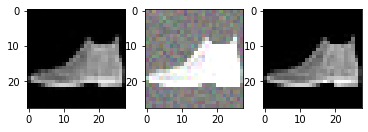

In [34]:
y_hat = autoencoder.predict(test_images_noise[:1])

plt.subplot(1, 3, 1)
plt.imshow(y_hat[0])

plt.subplot(1, 3, 2)
plt.imshow(test_images_noise[0])

plt.subplot(1, 3, 3)
plt.imshow(test_images[0])